In [1]:
import pandas as pd

s = pd.read_parquet("../data/processed/sessions_scored.parquet")
print(s.columns.tolist())
print(
    s.sort_values("suspicious_score", ascending=False)
    .head(10)[
        [
            "src_ip",
            "tool",
            "event_count",
            "rps",
            "indicator_hits",
            "suspicious_score",
            "label",
            "reasons",
        ]
    ]
    .to_string(index=False)
)

['session_id', 'src_ip', 'tool', 'start_ts', 'end_ts', 'event_count', 'unique_ports', 'indicator_hits', 'ind_lfi_etc_passwd', 'ind_path_traversal', 'ind_sql_injection', 'ind_cmd_injection', 'ind_wp_probe', 'duration_s', 'rps', 'rule_score', 'rule_reasons', 'ml_score', 'suspicious_score', 'label', 'reasons']
         src_ip     tool  event_count       rps  indicator_hits  suspicious_score       label                                                                                                                                      reasons
  152.58.39.168 gobuster         4591 46.846939               0          0.992743 attack_like                          [tool_fingerprint:dir_enum, behavior:burst_rps>=3, behavior:high_volume>=300, behavior:many_ports, ml_anomaly:high]
  152.58.39.151 gobuster        20446 43.781585               0          0.991659 attack_like                          [tool_fingerprint:dir_enum, behavior:burst_rps>=3, behavior:high_volume>=300, behavior:many_ports, ml_

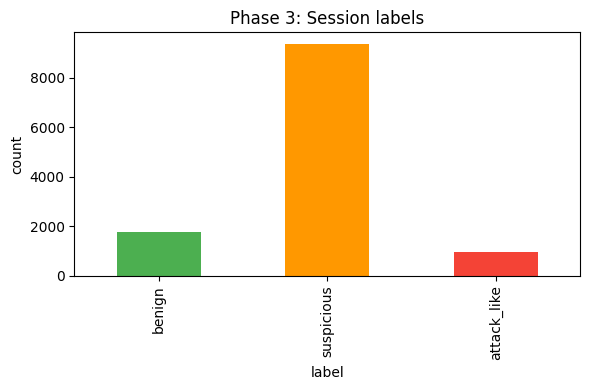

In [2]:
import matplotlib.pyplot as plt

counts = s["label"].value_counts().reindex(["benign", "suspicious", "attack_like"])
ax = counts.plot(kind="bar", color=["#4CAF50", "#FF9800", "#F44336"], figsize=(6, 4))
ax.set_title("Phase 3: Session labels")
ax.set_xlabel("label")
ax.set_ylabel("count")
plt.tight_layout()
plt.show()

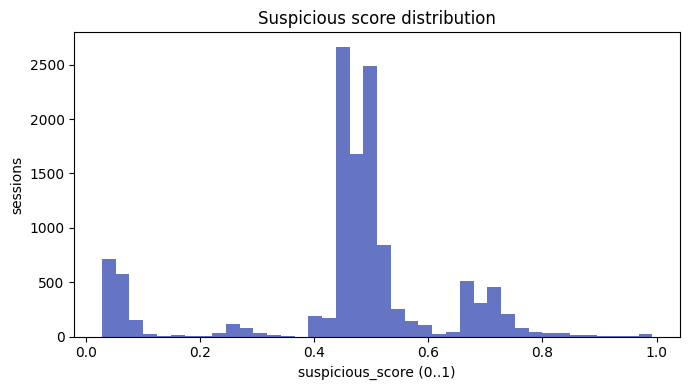

In [3]:
plt.figure(figsize=(7, 4))
plt.hist(s["suspicious_score"], bins=40, alpha=0.8, color="#3f51b5")
plt.title("Suspicious score distribution")
plt.xlabel("suspicious_score (0..1)")
plt.ylabel("sessions")
plt.tight_layout()
plt.show()

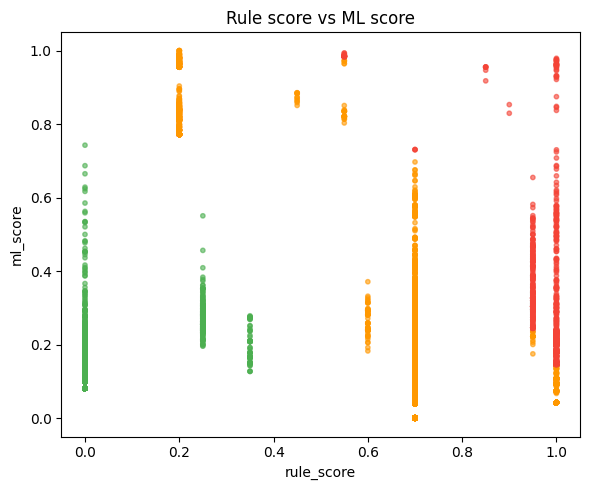

In [4]:
colors = s["label"].map(
    {"benign": "#4CAF50", "suspicious": "#FF9800", "attack_like": "#F44336"}
)
plt.figure(figsize=(6, 5))
plt.scatter(s["rule_score"], s["ml_score"], s=10, c=colors, alpha=0.6)
plt.title("Rule score vs ML score")
plt.xlabel("rule_score")
plt.ylabel("ml_score")
plt.tight_layout()
plt.show()

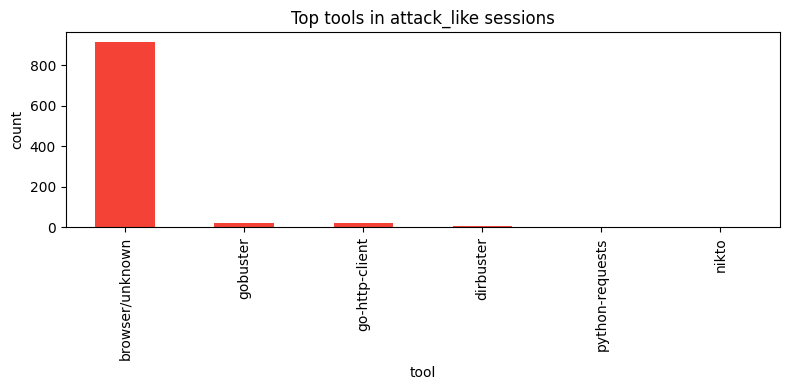

In [5]:
tool_counts = s[s["label"] == "attack_like"]["tool"].value_counts().head(10)

tool_counts.plot(kind="bar", figsize=(8, 4), color="#F44336")
plt.title("Top tools in attack_like sessions")
plt.xlabel("tool")
plt.ylabel("count")
plt.tight_layout()
plt.show()

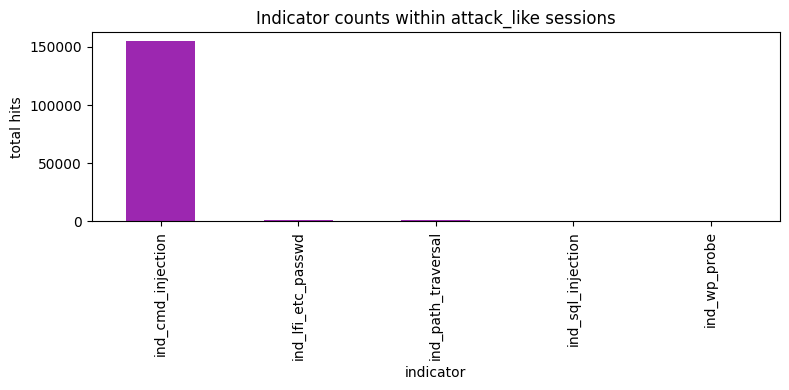

In [6]:
cols = [
    "ind_lfi_etc_passwd",
    "ind_path_traversal",
    "ind_sql_injection",
    "ind_cmd_injection",
    "ind_wp_probe",
]
attack_ind = s[s["label"] == "attack_like"][cols].sum().sort_values(ascending=False)
attack_ind

attack_ind.plot(kind="bar", figsize=(8, 4), color="#9C27B0")
plt.title("Indicator counts within attack_like sessions")
plt.xlabel("indicator")
plt.ylabel("total hits")
plt.tight_layout()
plt.show()

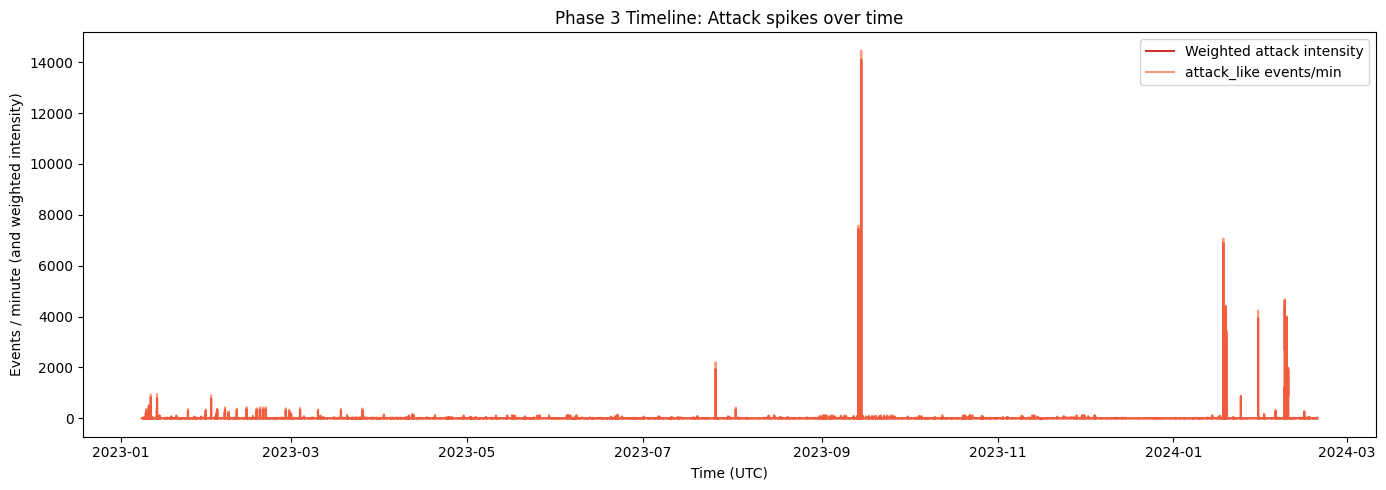

In [7]:
import pyarrow.dataset as ds

# 1) Load scored sessions (small)
sessions = pd.read_parquet(
    "../data/processed/sessions_scored.parquet",
    columns=["session_id", "label", "suspicious_score"],
)
sessions["label"] = sessions["label"].astype("category")

# 2) Load ONLY needed columns from session_events shards (stream-ish)
events_ds = ds.dataset("../data/processed/session_events", format="parquet")
events = events_ds.to_table(columns=["session_id", "ts"]).to_pandas()

# 3) Parse timestamps and join label/score onto each event
events["ts"] = pd.to_datetime(events["ts"], utc=True, errors="coerce")
events = events.dropna(subset=["ts", "session_id"])
events = events.merge(sessions, on="session_id", how="left")

# 4) Bucket events by time (per minute). You can change to '5min' or '1H'
events["minute"] = events["ts"].dt.floor("1min")

# Counts by label per minute
counts = events.groupby(["minute", "label"]).size().unstack(fill_value=0).sort_index()

# Weighted intensity (sum of suspicious_score per minute) — nicer “spike strength”
events["weight"] = events["suspicious_score"].fillna(0.0)
intensity = events.groupby("minute")["weight"].sum().sort_index()

# 5) Plot
plt.figure(figsize=(14, 5))
plt.plot(
    intensity.index,
    intensity.values,
    color="#d32f2f",
    linewidth=1.5,
    label="Weighted attack intensity",
)

# Optional: overlay raw counts for attack_like
if "attack_like" in counts.columns:
    plt.plot(
        counts.index,
        counts["attack_like"],
        color="#ff7043",
        alpha=0.7,
        label="attack_like events/min",
    )

plt.title("Phase 3 Timeline: Attack spikes over time")
plt.xlabel("Time (UTC)")
plt.ylabel("Events / minute (and weighted intensity)")
plt.legend()
plt.tight_layout()
plt.show()

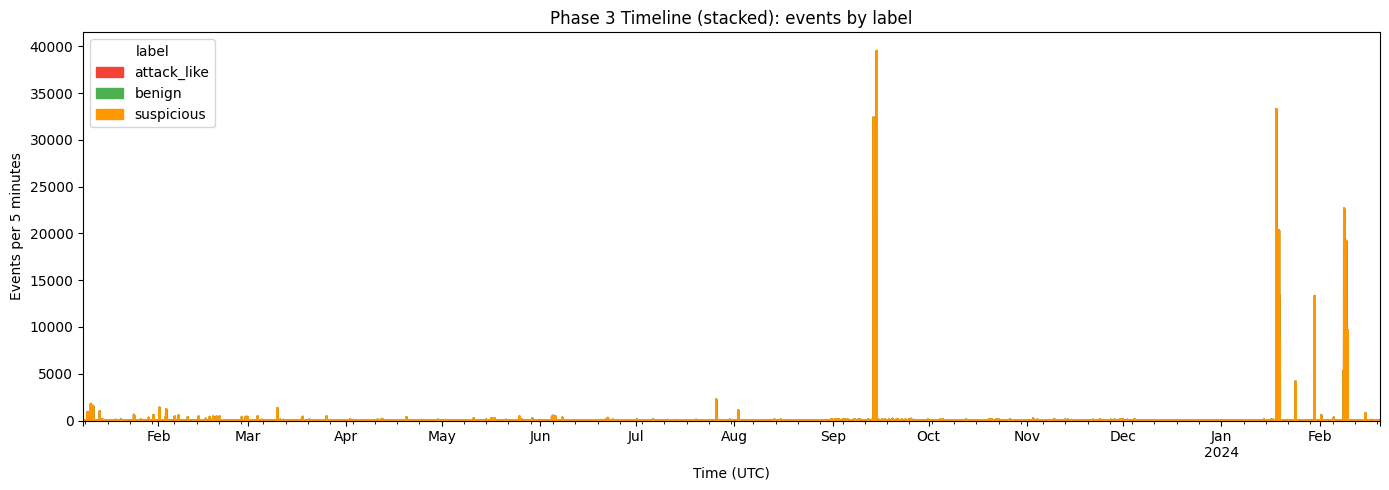

In [8]:
counts_5m = counts.resample("5min").sum()

ax = counts_5m.plot(
    kind="area",
    stacked=True,
    figsize=(14, 5),
    color={"benign": "#4caf50", "suspicious": "#ff9800", "attack_like": "#f44336"},
)
ax.set_title("Phase 3 Timeline (stacked): events by label")
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Events per 5 minutes")
plt.tight_layout()
plt.show()